In [12]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("../datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT +"datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [13]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


In [15]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [16]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [17]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [18]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


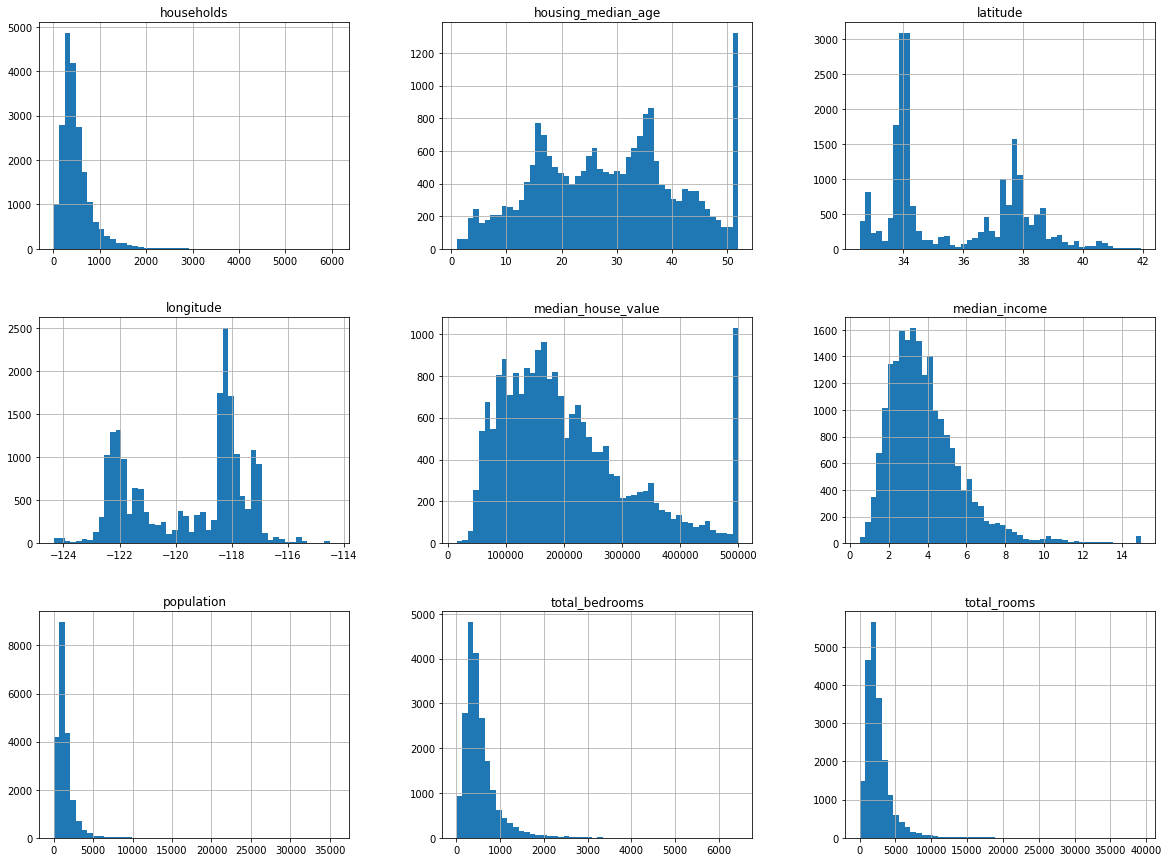

In [19]:
%matplotlib inline

import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [30]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

In [31]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [33]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

불행히 housing dataset은 identifier column가지고 있지 않아서 ID를 사용

In [34]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [35]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [36]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [38]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5 , 5.0, inplace=True)

In [39]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [40]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

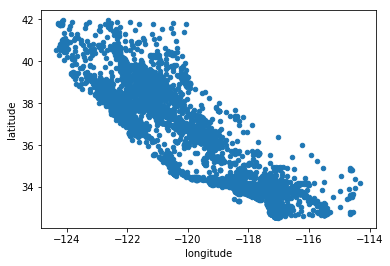

In [41]:
housing.plot(kind="scatter", x="longitude", y="latitude")

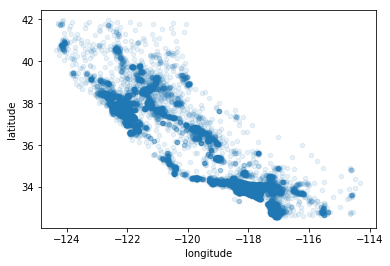

In [42]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.1)

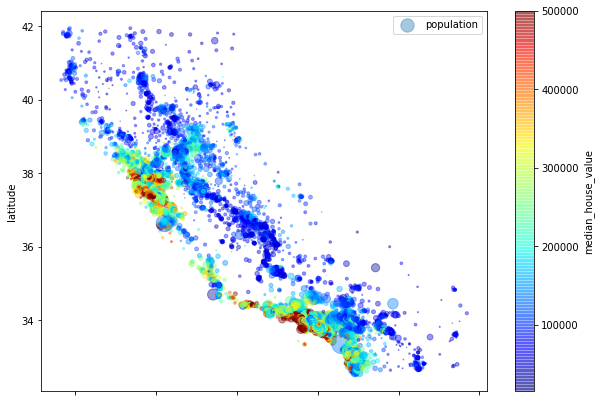

In [43]:
housing.plot(kind="scatter", x="longitude",y="latitude", alpha=0.4, s=housing["population"]/100,
            label="population", figsize=(10,7), c="median_house_value", cmap = plt.get_cmap("jet"),
             colorbar=True,)
plt.legend()

In [44]:
corr_matrix = housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
income_cat            0.643892
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

/Users/jaejin/dev/tensorflow/jupyter/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f5dbcf8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10b6303c8>]], dtype=object)

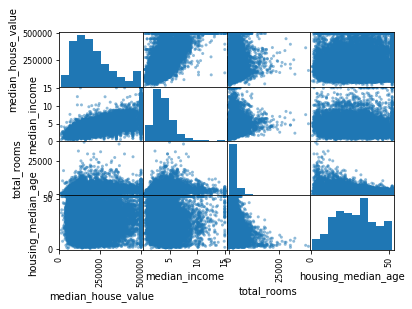

In [47]:
from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value","median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes])

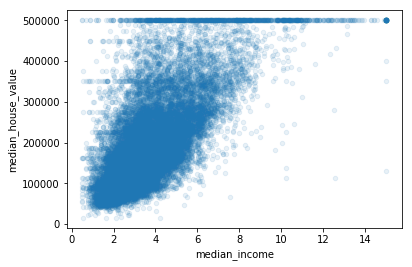

In [49]:
housing.plot(kind="scatter", x="median_income",y="median_house_value", alpha=0.1)

In [52]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
income_cat                  0.643892
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

In [53]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [54]:
housing.dropna(subset=["total_bedrooms"]) # option 1

housing.drop("total_bedrooms", axis=1)
median = housing["total_bedrooms"].median() # option 2

housing["total_bedrooms"].fillna(median, inplace=True) # option 3

In [55]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

In [56]:
housing_num = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [63]:
imputer.statistics_
housing_num.median().values

X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns = housing_num.columns)

In [65]:
housing_cat = housing["ocean_proximity"]
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [68]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]


array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0])

In [69]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [70]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [78]:
from sklearn.preprocessing import CategoricalEncoder
cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1,1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

ImportError: cannot import name 'CategoricalEncoder'

In [79]:
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

NameError: name 'housing_cat_reshaped' is not defined

In [80]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


In [81]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('imputer', Imputer(strategy="median")),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler',StandardScaler()),])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [95]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [96]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

In [97]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [98]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [99]:
housing_prepared.shape


(16512, 17)

In [100]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

/Users/jaejin/dev/tensorflow/jupyter/lib/python3.5/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [101]:
# let's try the full pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 203408.  326304.  204304.   58800.  194208.]


In [102]:
print("Labels:", list(some_labels))


Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [103]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68376.837719088115

In [104]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [105]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [106]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring = "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)


In [108]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation: ", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [ 70307.54079165  67270.94561829  71361.89886493  68889.91784739
  70992.94150631  74140.66907294  70607.72083897  70576.13836762
  76433.16342183  70270.96266671]
Mean: 71085.1898997
Standard deviation:  2431.96102969


In [111]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66874.76709057  66608.120256    70575.91118868  74168.39425959
  67684.77911556  71112.55058388  64782.65896552  67706.35727123
  71080.40484136  67690.32715834]
Mean: 68828.4270731
Standard deviation:  2661.47715273


In [112]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

NameError: name 'RandomForestRegressor' is not defined